C:\Users\Balazs\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


clf__alpha: 0.0001
tfidf__use_idf: True
vect__ngram_range: (1, 1)
0.6648471615720524


Text(33.0, 0.5, 'actual')

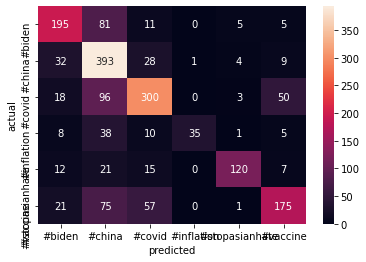

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

twitter = pd.read_csv('C:/Users/Balazs/Documents/spark/twitter1.csv')
stop_word = pd.read_csv('C:/Users/Balazs/Documents/spark/stopwords_bn.txt', header=None)
stop_word_list = stop_word[0].tolist()


train, test = train_test_split(twitter, train_size=0.8, random_state=770775)

# pipeline the whole process
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_word_list, ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=770775, max_iter=5, tol=None))
])

# tuning
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2,2)], # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 5e-3, 1e-3, 5e-4, 1e-4),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(train.text[:500], train.label[:500])
# prediction
gs_predict = gs_clf.predict(test.text)
gs_accuracy = np.mean(gs_predict == test.label)

# check the best score
#  best mean score
gs_clf.best_score_
# the parameters setting corresponding to that score
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

best_ngram_range = gs_clf.best_params_['vect__ngram_range']
best_tfidf = gs_clf.best_params_['tfidf__use_idf']
best_clf_alpha = gs_clf.best_params_['clf__alpha']

# retrain a model based on the best parameter I can get
text_clf_opt = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_word_list, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf = True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, random_state=770775, max_iter=5, tol=None))
])
text_clf_opt.fit(train.text, train.label)
predicted = text_clf_opt.predict(test.text)
accuracy = np.mean(predicted == test.label)
print(accuracy)

tag_name = list(test.label.unique())
# classification report so far doesn't work
# performance = classification_report(test.label, predicted, target_names=tag_name)
performance = classification_report(y_true=test.label, y_pred=predicted)

# check which combinations are most likely to be confused with each other
labels = ['#biden', '#china', '#covid', '#inflation', '#stopasianhate', '#vaccine']
test_label = test.label
confusion = confusion_matrix(test_label, predicted)
sns.heatmap(confusion, annot=True, fmt='g')
plt.xticks(np.arange(6)+.5, labels=labels)
plt.yticks(np.arange(6)+.5, labels=labels)
plt.xlabel('predicted')
plt.ylabel('actual')